# Visionar gradientes

In [29]:
import cv2
import seaborn as sns
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm import tqdm
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
import shutil

import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
import torchxrayvision as xrv
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, models
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import f1_score,precision_score
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
from time import sleep

In [30]:
def get_jpg_paths(directory):
    """
    Recorre una carpeta y sus subcarpetas para encontrar archivos con extensión .jpeg.
    Retorna un DataFrame con una columna 'relative_path' que contiene los caminos relativos de las imágenes.
    
    Parameters:
        directory (str): El path a la carpeta raíz que contiene las subcarpetas.
    
    Returns:
        pd.DataFrame: Un DataFrame con los caminos relativos de las imágenes .jpeg.
    """
    jpg_paths = []
    
    # Recorre todas las carpetas y archivos dentro del directorio
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.jpg'):  # Aseguramos que la extensión sea .jpeg
                # Calculamos el camino relativo
                relative_path = os.path.relpath(os.path.join(root, file), start=directory)
                jpg_paths.append(relative_path)
    
    # Creamos un DataFrame con los resultados
    df = pd.DataFrame(jpg_paths, columns=['relative_path'])
    return df
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img
def visualize_true_vs_pred(y_pred, y_true, title=""):
    """
    y_pred, y_true: deben ser dos numpy arrays, que contengan las clases predichas y reales, respectivamente.
    title: un string que se añadirá en el título, para poder diferenciar la matriz de confusión del conjunto de entrenamiento y validación
    """
    
    prec = precision_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    confusion_mat = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
    disp.plot(ax=ax)
    Title = f"F1 Score = {round(f1, 3)}, Precisión = {round(100 * prec, 2)}"
    if title: Title = title + ": " + Title
    plt.title(Title, fontsize=16)  
    plt.xlabel('Predicted label', fontsize=14)  
    plt.ylabel('True label', fontsize=14)  
    plt.show()

In [31]:
df_fallos=pd.read_csv('defectos_info.csv')
df_fallos

,relative_path,defecto
0,kos01\Part0.jpg,0
1,kos01\Part1.jpg,0
2,kos01\Part2.jpg,0
3,kos01\Part3.jpg,0
4,kos01\Part4.jpg,0
...,...,...
498,kos50\Part4_res.jpg,1
499,kos50\Part4_rot.jpg,1
500,kos50\Part5.jpg,0
501,kos50\Part6.jpg,0


In [32]:
# Preparar los datos

# Filtrar las imágenes con defecto y sin defecto
df_defecto = df_fallos[df_fallos['defecto'] == 1]
df_no_defecto = df_fallos[df_fallos['defecto'] == 0]

# Seleccionar 120 imágenes de cada tipo para el conjunto de entrenamiento
df_defecto_train = df_defecto.sample(n=135, random_state=42)
df_no_defecto_train = df_no_defecto.sample(n=135, random_state=42)

# El resto de las imágenes se utilizarán para el conjunto de validación
df_defecto_val = df_defecto.drop(df_defecto_train.index)
df_no_defecto_val = df_no_defecto.drop(df_no_defecto_train.index)

# Combinar los conjuntos de entrenamiento y validación
df_train = pd.concat([df_defecto_train, df_no_defecto_train]).reset_index(drop=True)
df_val = pd.concat([df_defecto_val, df_no_defecto_val]).reset_index(drop=True)

# Definir el dataset personalizado
class DefectDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Definir las transformaciones
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.ToTensor(),
    transforms.Resize((704,256)),
    transforms.Normalize((0.5,), (0.25,))
])
# Crear los datasets y dataloaders
train_dataset = DefectDataset(df_train, root_dir='data_augmentation', transform=transform)
val_dataset = DefectDataset(df_val, root_dir='data_augmentation', transform=transform)

# Crear los dataloaders con num_workers
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [33]:
# Cargar el modelo preentrenado
model = models.resnet34(pretrained=False)

# Modificar la capa fully connected para que coincida con el número de clases en el checkpoint
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Cargar los pesos del modelo guardado
model.load_state_dict(torch.load('modelo_resnet34.pth', map_location=DEVICE))

# Mover el modelo al dispositivo adecuado (CPU o GPU)
model = model.to(DEVICE)

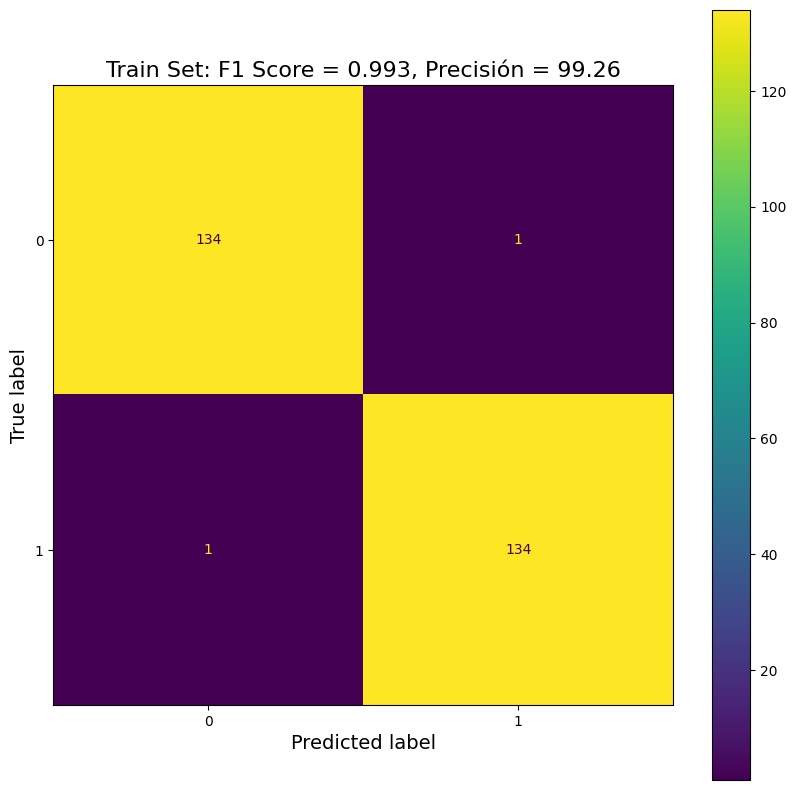

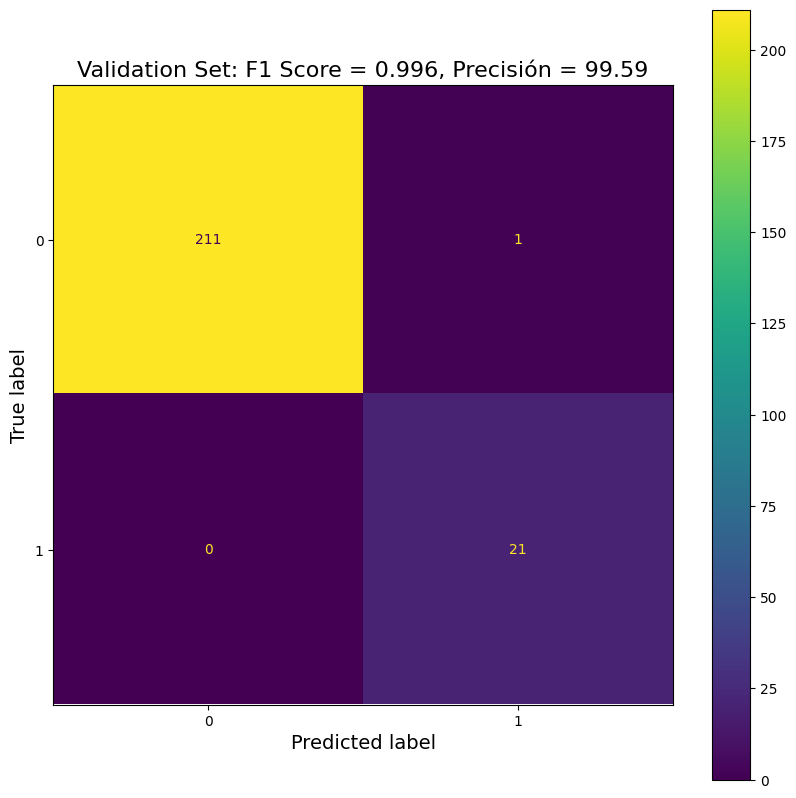

In [34]:
# Obtener predicciones para el conjunto de entrenamiento
model.eval()
train_preds = []
train_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)  
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Obtener predicciones para el conjunto de validación
val_preds = []
val_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE) 
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Visualizar la matriz de confusión para el conjunto de entrenamiento
visualize_true_vs_pred(np.array(train_preds), np.array(train_labels), title="Train Set")

# Visualizar la matriz de confusión para el conjunto de validación
visualize_true_vs_pred(np.array(val_preds), np.array(val_labels), title="Validation Set")

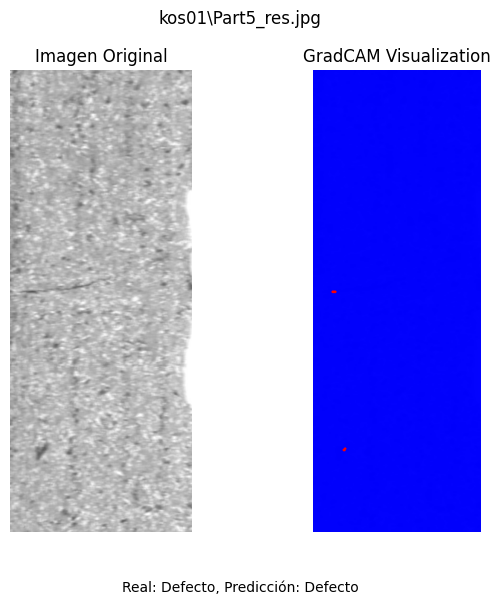

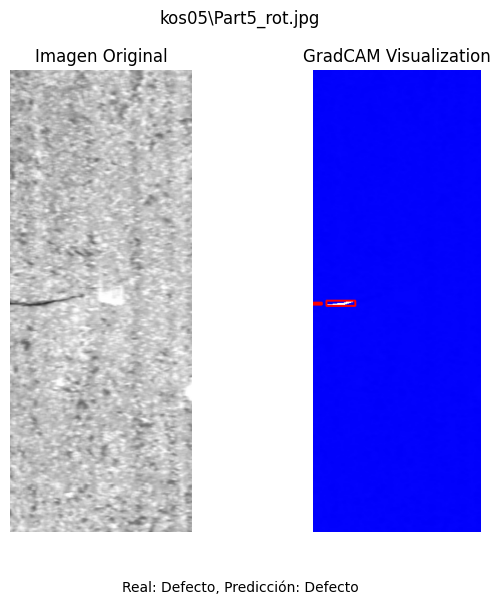

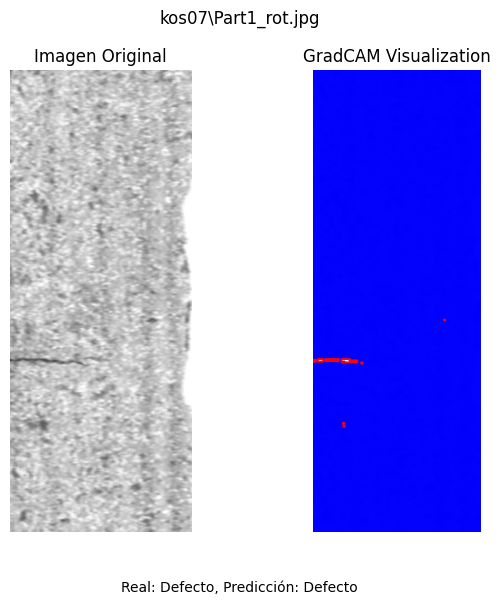

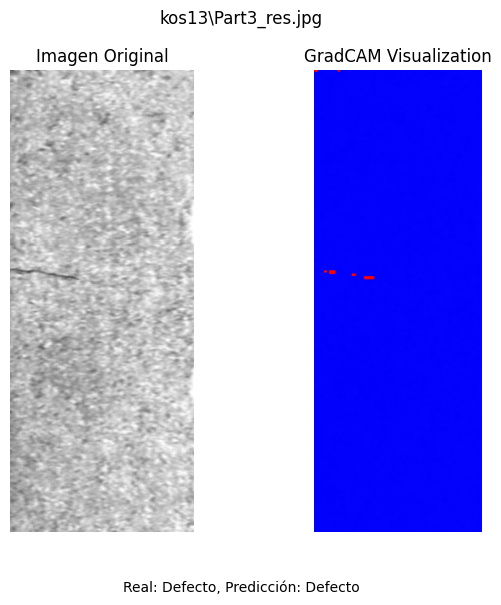

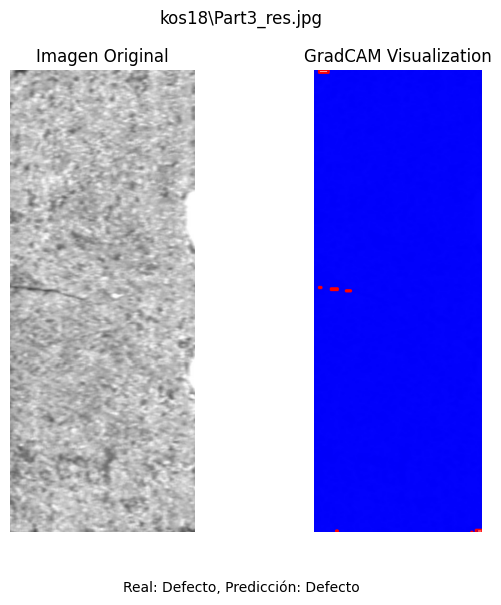

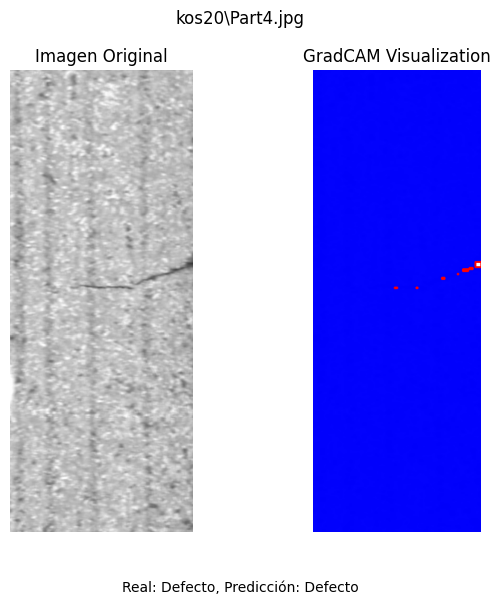

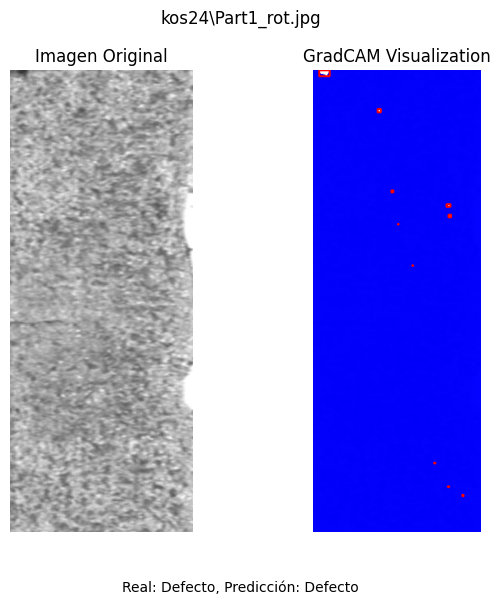

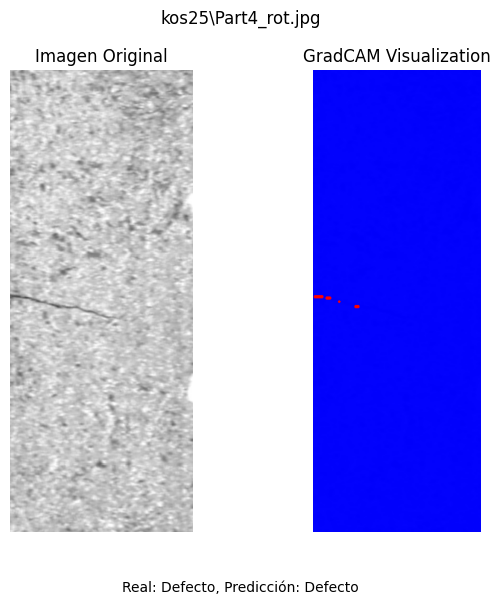

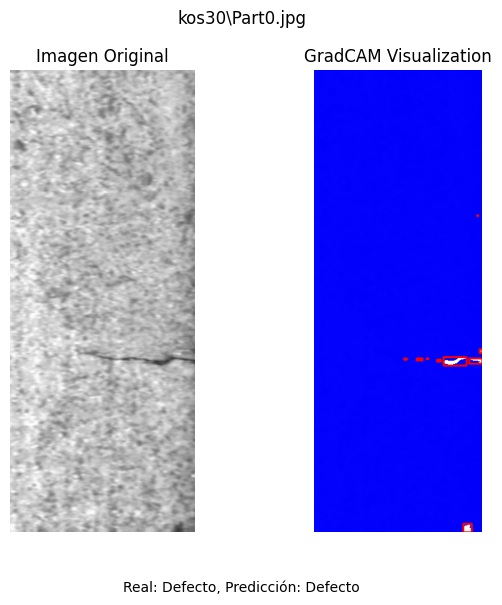

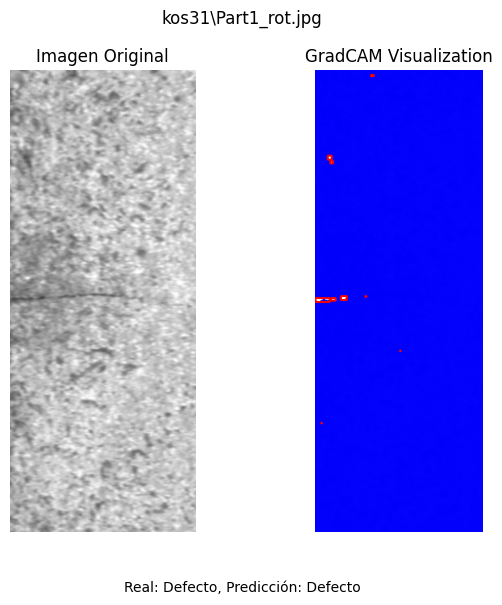

In [35]:
# Definir el target layer para GradCAM
target_layer = model.layer1[-1]

# Crear una instancia de GradCAM
cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

# Obtener las imágenes y labels del conjunto de validación con label=1 y predicted=1
images_to_visualize = []
labels_to_visualize = []
preds_to_visualize = []
file_names = []

for i, (images, labels) in enumerate(val_loader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    for j in range(len(labels)):
        if labels[j] == 1 and predicted[j] == 1:
            images_to_visualize.append(images[j].cpu().numpy().transpose(1, 2, 0))
            labels_to_visualize.append(labels[j].item())
            preds_to_visualize.append(predicted[j].item())
            file_names.append(df_val.iloc[i * val_loader.batch_size + j, 0])
            if len(images_to_visualize) >= 10:
                break
    if len(images_to_visualize) >= 10:
        break

# Aplicar GradCAM y mostrar las imágenes
for idx, img in enumerate(images_to_visualize):
    img = img.astype(np.float32) / 255.0  # Normalize the image to the range [0, 1]
    grayscale_cam = cam(input_tensor=torch.tensor(img.transpose(2, 0, 1)).unsqueeze(0).to(DEVICE))

    visualization = show_cam_on_image(img, grayscale_cam[0], use_rgb=True)
    
    # Convertir la imagen a escala de grises ya que al tener un gradiente binario no es mas fácil tratando con una imagen en escala de grises
    gray_visualization = cv2.cvtColor(visualization, cv2.COLOR_RGB2GRAY)
    
    # Umbralizar la imagen para obtener los píxeles blancos
    _, binary_visualization = cv2.threshold(gray_visualization, 240, 255, cv2.THRESH_BINARY)
    
    # Encontrar contornos en la imagen binaria
    contours, _ = cv2.findContours(binary_visualization, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Dibujar un bloque alrededor de los contornos encontrados
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(visualization, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Cargar la imagen original desde el archivo
    original_img_path = os.path.join('data_augmentation', file_names[idx])
    original_img = Image.open(original_img_path).convert('RGB')
    original_img = np.array(original_img)

    # Mostrar la imagen original y la visualización lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(7, 6))
    axes[0].imshow(original_img)
    axes[0].set_title('Imagen Original')
    axes[0].axis('off')
    axes[1].imshow(visualization)
    axes[1].set_title('GradCAM Visualization')
    axes[1].axis('off')
    fig.suptitle(file_names[idx])
    if labels_to_visualize[idx] == 1 and preds_to_visualize[idx] == 1:
        fig.text(0.5, 0.01, f'Real: Defecto, Predicción: Defecto', ha='center')
    else:
        fig.text(0.5, 0.01, f'Real: {labels_to_visualize[idx]}, Predicción: {preds_to_visualize[idx]}', ha='center')
    plt.show()